In [1]:
import sys
sys.path.append('/data/idvor/python_scripts/')

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, MDS

In [2]:
peaRsaColor = '#6AFC8F'
eucRsaColor = '#6CA7E6'
speRsaColor = '#D86AFC'
ckaColor = '#F55A27'
ccaColor = '#F5E750'
funNames = ['peaRsa', 'eucRsa', 'speRsa', 'cca', 'cka']
rsaMetrics = ['peaRsa', 'eucRsa', 'speRsa']

# Using the model zoo
The model zoo is currently pulling from Tensorflow Hub. Each model is enumerated in the hubModels.json file in the python_scripts folder. To load the model and extract representations, I wrote functions housed in the file hubReps.py (which uses other functions shared in this project) that can be used in ACCRE (for the purpose of parallelization). You can see how these work in the folder slurm_scripts, the slurm script is called "hubReps.slurm". The datasets used for the representations were loaded and processed ahead of time to be usable quickly across all models, you can see how datasets are created in the dataset.py script.

# Using precomputed similarity scores
Note that similarities were computed using two different metrics (and therefore each analysis is duplicated).

In [3]:
# Load hub similarity data
hubPath = "../outputs/masterOutput/hubSimsImagenet.csv"
df = pd.read_csv(hubPath, index_col=0)

# Remove repeat models
repeatModels = ['tf2-preview/inception_v3/feature_vector', 'tf2-preview/mobilenet_v2/feature_vector', 'experts/bit/r50x1/in21k/food', 'experts/bit/r50x1/in21k/arthropod', 'experts/bit/r50x1/in21k/instrument']
# Remove any row with a repeat model
df = df[~df.model1.isin(repeatModels)]
df = df[~df.model2.isin(repeatModels)]
df.head()

# Load hud mobel info
with open("../python_scripts/hubModels.json") as f:
    hubInfo = json.load(f)

# Get each type of model
modelTypes = np.sort(np.unique([hubInfo[key]['type'] for key in hubInfo.keys()]))
modelTypes

# Reorder models by type
models = []
for modelType in modelTypes:
    # Get models that are of this type
    tmp = [key for key in hubInfo.keys() if hubInfo[key]['type'] == modelType]

    # Filter to only models with hub sims
    tmp = [key for key in tmp if key in df.model1.unique() or key in df.model2.unique()]

    # Sort by name then add to list
    models += np.sort(tmp).tolist()
    

## Similarity matrices

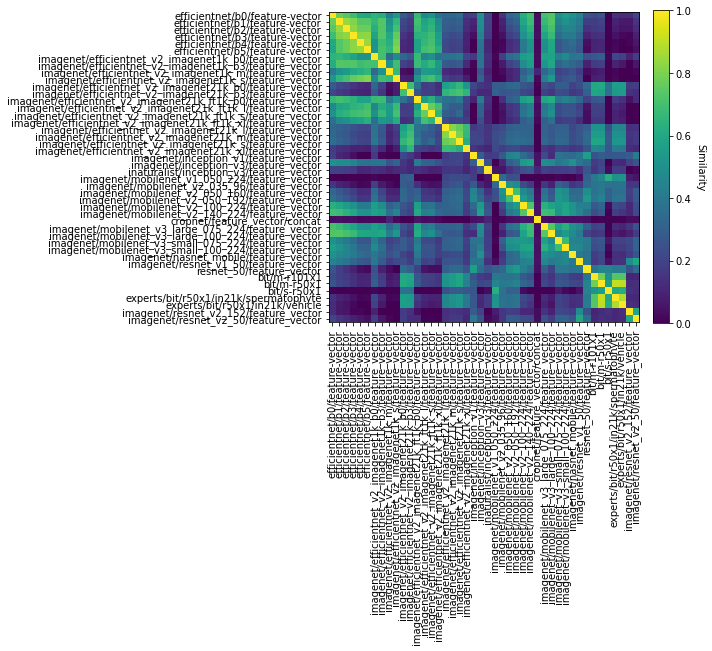

In [4]:
# Create a heatmap for rsa by looping through rows similarity df
rsaHeatmap = np.zeros((len(models), len(models)))
for idx, row in df.iterrows():
    # Find the index of the models
    i = np.where(models == np.array(row.model1))[0][0]
    j = np.where(models == np.array(row.model2))[0][0]
    rsaHeatmap[i, j] = row.eucRsa
    rsaHeatmap[j, i] = row.eucRsa

rsaHeatmap[rsaHeatmap == 0] = 1

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(rsaHeatmap, vmin=0, vmax=1)

# Add scale
ax.set_xticks(np.arange(len(models)))
ax.set_yticks(np.arange(len(models)))
ax.set_xticklabels(models, rotation=90)
ax.set_yticklabels(models)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Similarity", rotation=-90, va="bottom")

# Save figure
plt.tight_layout()
plt.savefig("../visualization/maxVarSimMatRSA.svg", dpi=300)

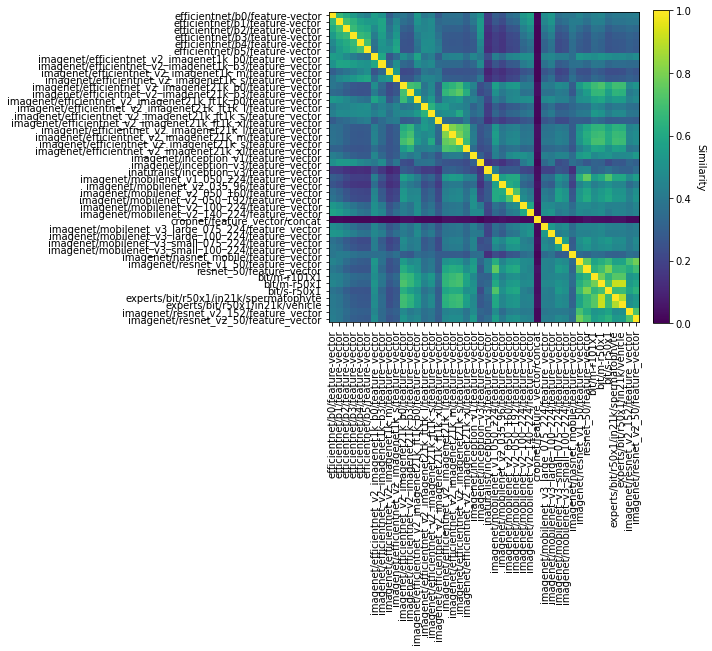

In [5]:
# Create a heatmap for rsa by looping through rows similarity df
ckaHeatmap = np.zeros((len(models), len(models)))
for idx, row in df.iterrows():
    # Find the index of the models
    i = np.where(models == np.array(row.model1))[0][0]
    j = np.where(models == np.array(row.model2))[0][0]
    ckaHeatmap[i, j] = row.cka
    ckaHeatmap[j, i] = row.cka

ckaHeatmap[ckaHeatmap == 0] = 1

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(ckaHeatmap, vmin=0, vmax=1)

# Add scale
ax.set_xticks(np.arange(len(models)))
ax.set_yticks(np.arange(len(models)))
ax.set_xticklabels(models, rotation=90)
ax.set_yticklabels(models)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Similarity", rotation=-90, va="bottom")

# Save figure
plt.tight_layout()
plt.savefig("../visualization/maxVarSimMatCKA.svg", dpi=300)

## Histogram of model similarities

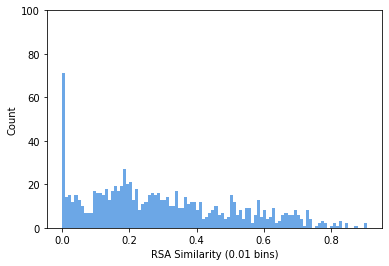

In [6]:
# Plot histogram of rsa values
plt.hist(np.clip(df.eucRsa, a_min=0, a_max=1), bins=100, color=eucRsaColor)

# Label axes
plt.xlabel("RSA Similarity (0.01 bins)")
plt.ylabel("Count")

# Change y limits
plt.ylim(0, 100)

# Save figure
plt.savefig('../visualization/maxVarHistRSA.svg')


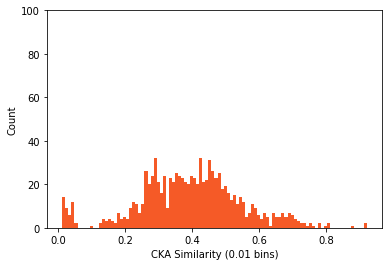

In [7]:
plt.hist(np.clip(df.cka, a_min=0, a_max=1), bins=100, color=ckaColor)

# Label axes
plt.xlabel("CKA Similarity (0.01 bins)")
plt.ylabel("Count")

plt.ylim(0, 100)

# Save figure
plt.savefig('../visualization/maxVarHistCKA.svg')

## Dimensionality reduction/scaling visualizations
Note how the hubInfo json has information about each model and how it is used here.

In [8]:
modelTypeColors = plt.cm.tab20(range(len(modelTypes)))

# Loop through all models and get their color
modelColors = []
modelGrouping = []
for model in models:
    # Get index of modeltype in modelTypes
    idx = np.where(modelTypes == hubInfo[model]['type'])[0][0]
    modelColors.append(modelTypeColors[idx])

    # Add model type to groupings
    modelGrouping.append(hubInfo[model]['type'])

[t-SNE] Computing 43 nearest neighbors...
[t-SNE] Indexed 44 samples in 0.000s...
[t-SNE] Computed neighbors for 44 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 44 / 44
[t-SNE] Mean sigma: 0.665570
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.048401
[t-SNE] KL divergence after 3000 iterations: 0.567314


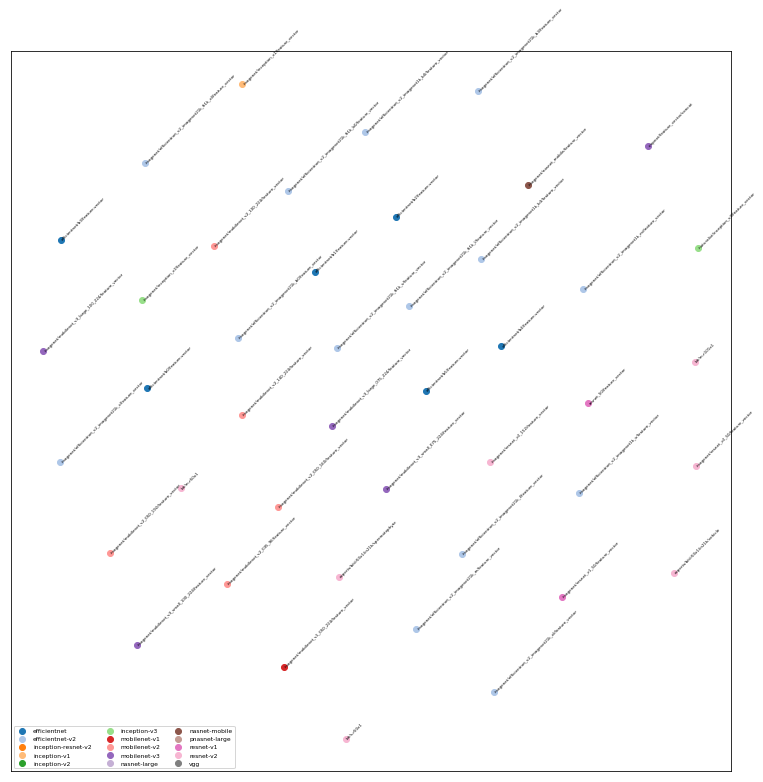

In [9]:
# Create a tsne plot for rsa similarity
rsaTsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=3000, metric="precomputed")
rsaTsne = rsaTsne.fit_transform(np.abs(1-rsaHeatmap))

# Plot tsnd
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
for (modelType, color) in zip(modelTypes, modelTypeColors):
    ax.scatter(rsaTsne[:, 0][modelGrouping == np.array(modelType)], rsaTsne[:, 1][modelGrouping == np.array(modelType)], color=color, label=modelType)

# Remove axis ticks/labels
ax.set_xticks([])
ax.set_yticks([])

# Add legend outside
fig.legend(loc='lower left', bbox_to_anchor=(0, 0), ncol=3, fancybox=True, shadow=False, prop={'size': 6})

# Save figure without text
plt.savefig('../visualization/maxVarTsneRSA.svg')

# Size up the figure
fig.set_figheight(10)
fig.set_figwidth(10)

# Add text for each dot
for i, txt in enumerate(models):
    # Note rotation
    ax.annotate(txt, (rsaTsne[:, 0][i], rsaTsne[:, 1][i]), rotation=45, size=4)

plt.savefig('../visualization/maxVarTsneRSA_text.svg')
fig.show()


[t-SNE] Computing 43 nearest neighbors...
[t-SNE] Indexed 44 samples in 0.000s...
[t-SNE] Computed neighbors for 44 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 44 / 44
[t-SNE] Mean sigma: 0.502465
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.284916
[t-SNE] KL divergence after 2600 iterations: 0.503586


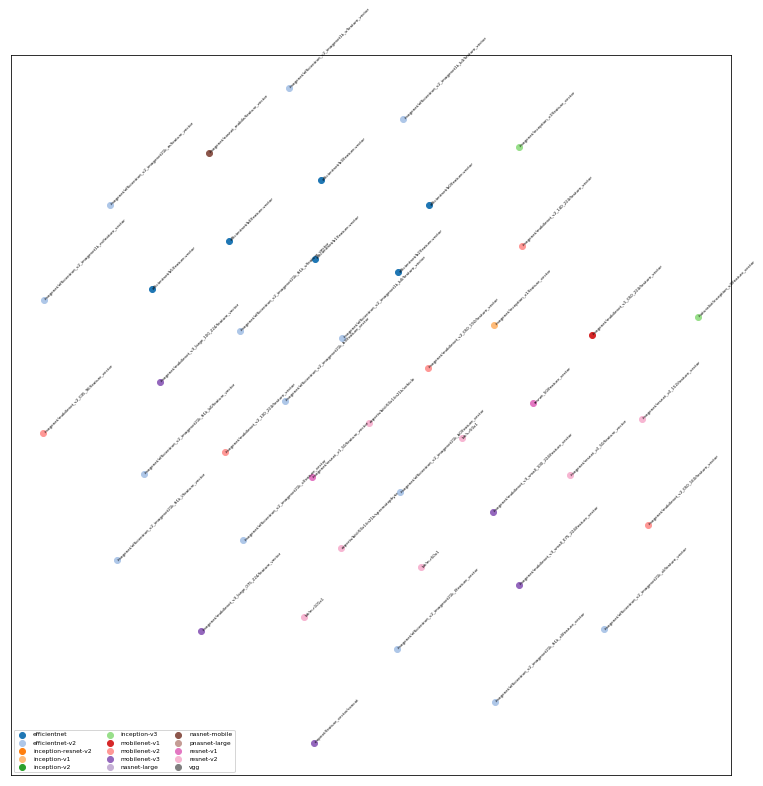

In [10]:
# Create a tsne plot for rsa similarity
ckaTsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=3000, metric="precomputed")
ckaTsne = ckaTsne.fit_transform(np.abs(1-ckaHeatmap))

# Plot tsnd
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
for (modelType, color) in zip(modelTypes, modelTypeColors):
    ax.scatter(ckaTsne[:, 0][modelGrouping == np.array(modelType)], ckaTsne[:, 1][modelGrouping == np.array(modelType)], color=color, label=modelType)

# Remove axis ticks/labels
ax.set_xticks([])
ax.set_yticks([])

# Add legend outside
fig.legend(loc='lower left', bbox_to_anchor=(0, 0), ncol=3, fancybox=True, shadow=False, prop={'size': 6})

# Save figure  
plt.savefig('../visualization/maxVarTsneCKA.svg')

# Size up the figure
fig.set_figheight(10)
fig.set_figwidth(10)

# Add text for each dot
for i, txt in enumerate(models):
    # Note rotation
    ax.annotate(txt, (ckaTsne[:, 0][i], ckaTsne[:, 1][i]), rotation=45, size=4)

plt.savefig('../visualization/maxVarTsneCKA_text.svg')
fig.show()

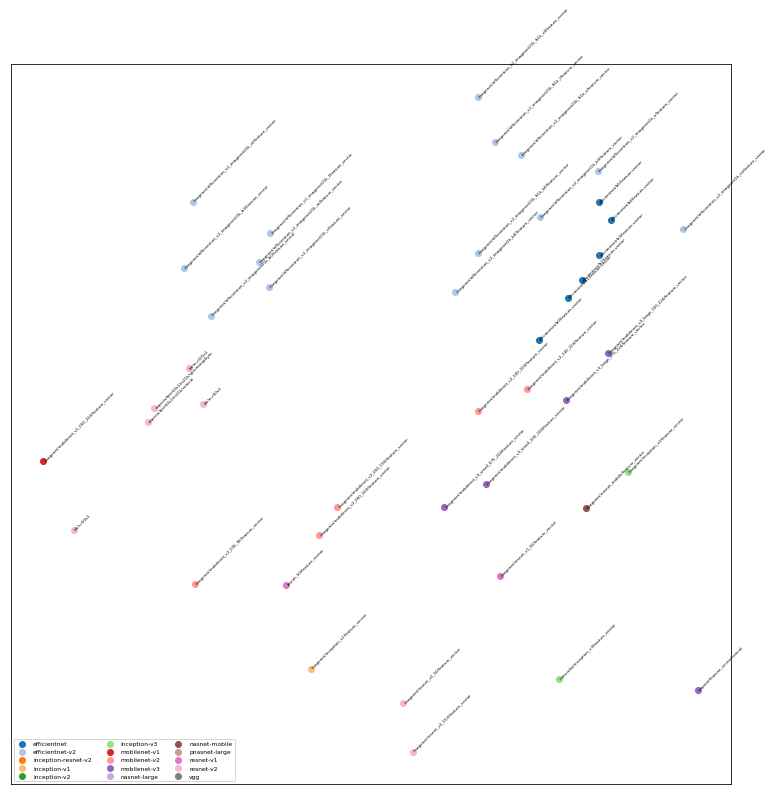

In [11]:
rsaMDS = MDS(n_components=2, metric=True, dissimilarity="precomputed")
rsaMDS = rsaMDS.fit_transform(np.abs(1-rsaHeatmap))

# Plot MDS
fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes([0, 0, 1, 1])
for (modelType, color) in zip(modelTypes, modelTypeColors):
    ax.scatter(rsaMDS[:, 0][modelGrouping == np.array(modelType)], rsaMDS[:, 1][modelGrouping == np.array(modelType)], color=color, label=modelType)
    
# Remove axis ticks/labels
ax.set_xticks([])
ax.set_yticks([])

# Add legend outside
fig.legend(loc='lower left', bbox_to_anchor=(0, 0), ncol=3, fancybox=True, shadow=False, prop={'size': 6})

# Add text
for i, txt in enumerate(models):
    # Add rotation
    ax.annotate(txt, (rsaMDS[:, 0][i], rsaMDS[:, 1][i]), rotation=45, size=4)

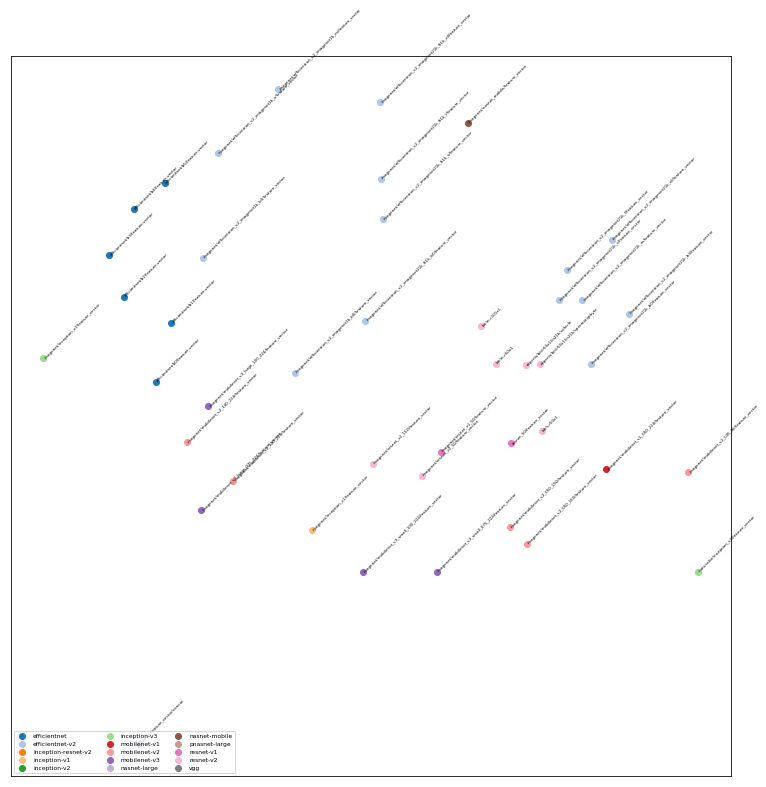

In [12]:
ckaMDS = MDS(n_components=2, metric=True, dissimilarity="precomputed")
ckaMDS = ckaMDS.fit_transform(np.abs(1-ckaHeatmap))

# Plot MDS
fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes([0, 0, 1, 1])
for (modelType, color) in zip(modelTypes, modelTypeColors):
    ax.scatter(ckaMDS[:, 0][modelGrouping == np.array(modelType)], ckaMDS[:, 1][modelGrouping == np.array(modelType)], color=color, label=modelType)

# Remove axis ticks/labels
ax.set_xticks([])
ax.set_yticks([])

# Add legend outside
fig.legend(loc='lower left', bbox_to_anchor=(0, 0), ncol=3, fancybox=True, shadow=False, prop={'size': 6})

# Add text
for i, txt in enumerate(models):
    # Add rotation
    ax.annotate(txt, (ckaMDS[:, 0][i], ckaMDS[:, 1][i]), rotation=45, size=4)
    


## Analysis of the same model zoo but using different datasets
Essentially repeat of above using different datasets.

In [13]:
# Load hub similarity data
hubPath = "../outputs/masterOutput/hubSimsNovset.csv"
df = pd.read_csv(hubPath, index_col=0)

# Remove repeat models
repeatModels = ['tf2-preview/inception_v3/feature_vector', 'tf2-preview/mobilenet_v2/feature_vector', 'experts/bit/r50x1/in21k/food', 'experts/bit/r50x1/in21k/arthropod', 'experts/bit/r50x1/in21k/instrument']
# Remove any row with a repeat model
df = df[~df.model1.isin(repeatModels)]
df = df[~df.model2.isin(repeatModels)]
df.head()

# Load hud mobel info
with open("../python_scripts/hubModels.json") as f:
    hubInfo = json.load(f)

# Get each type of model
modelTypes = np.sort(np.unique([hubInfo[key]['type'] for key in hubInfo.keys()]))
modelTypes

# Reorder models by type
models = []
for modelType in modelTypes:
    # Get models that are of this type
    tmp = [key for key in hubInfo.keys() if hubInfo[key]['type'] == modelType]

    # Filter to only models with hub sims
    tmp = [key for key in tmp if key in df.model1.unique() or key in df.model2.unique()]

    # Sort by name then add to list
    models += np.sort(tmp).tolist()

modelTypeColors = plt.cm.tab20(range(len(modelTypes)))

# Loop through all models and get their color
modelColors = []
modelGrouping = []
for model in models:
    # Get index of modeltype in modelTypes
    idx = np.where(modelTypes == hubInfo[model]['type'])[0][0]
    modelColors.append(modelTypeColors[idx])

    # Add model type to groupings
    modelGrouping.append(hubInfo[model]['type'])

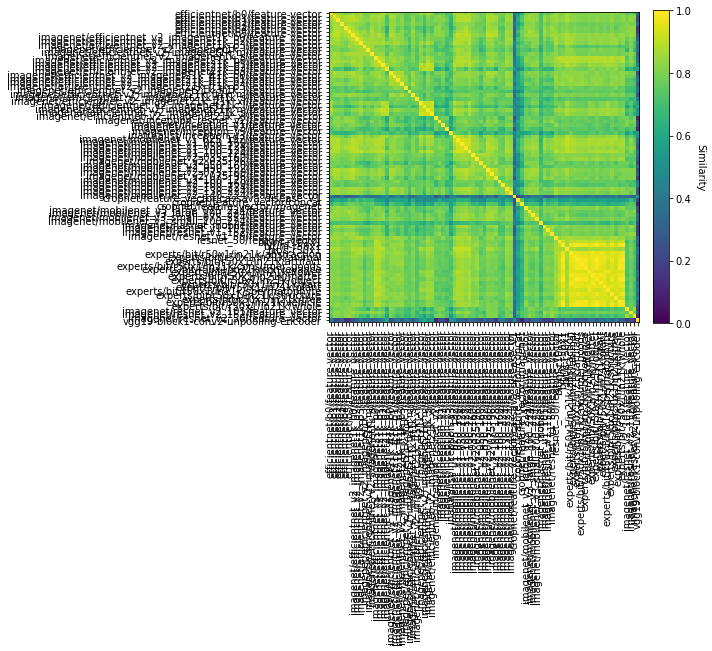

In [14]:
# Create a heatmap for rsa by looping through rows similarity df
rsaHeatmap = np.zeros((len(models), len(models)))
for idx, row in df.iterrows():
    # Find the index of the models
    i = np.where(models == np.array(row.model1))[0][0]
    j = np.where(models == np.array(row.model2))[0][0]
    rsaHeatmap[i, j] = row.eucRsa
    rsaHeatmap[j, i] = row.eucRsa

rsaHeatmap[rsaHeatmap == 0] = 1

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(rsaHeatmap, vmin=0, vmax=1)

# Add scale
ax.set_xticks(np.arange(len(models)))
ax.set_yticks(np.arange(len(models)))
ax.set_xticklabels(models, rotation=90)
ax.set_yticklabels(models)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Similarity", rotation=-90, va="bottom")

# Save figure
plt.tight_layout()
plt.savefig("../visualization/maxVarSimMatRSA.svg", dpi=300)

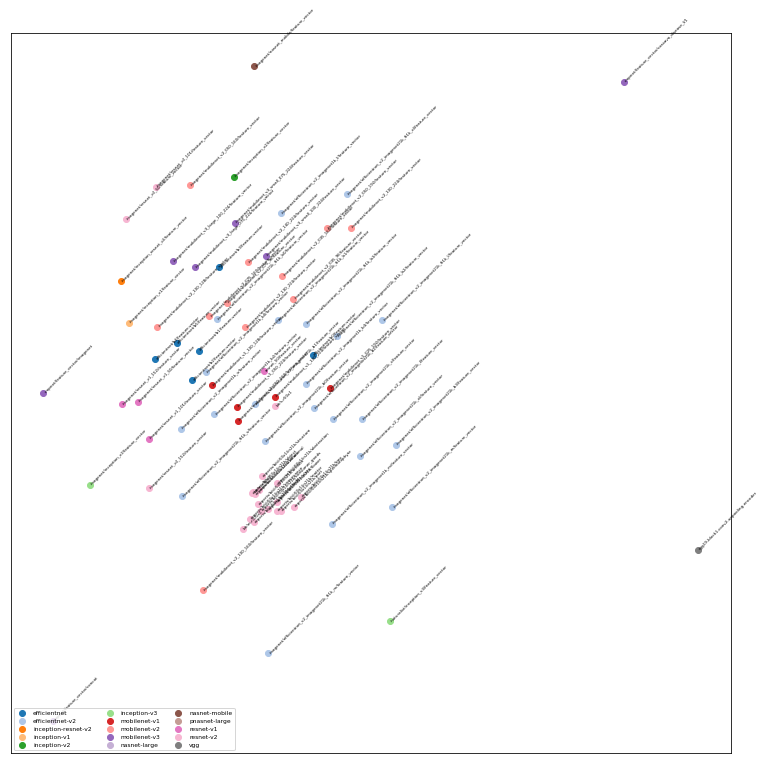

In [15]:
rsaMDS = MDS(n_components=2, metric=True, dissimilarity="precomputed")
rsaMDS = rsaMDS.fit_transform(np.abs(1-rsaHeatmap))

# Plot MDS
fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes([0, 0, 1, 1])
for (modelType, color) in zip(modelTypes, modelTypeColors):
    ax.scatter(rsaMDS[:, 0][modelGrouping == np.array(modelType)], rsaMDS[:, 1][modelGrouping == np.array(modelType)], color=color, label=modelType)
    
# Remove axis ticks/labels
ax.set_xticks([])
ax.set_yticks([])

# Add legend outside
fig.legend(loc='lower left', bbox_to_anchor=(0, 0), ncol=3, fancybox=True, shadow=False, prop={'size': 6})

# Add text
for i, txt in enumerate(models):
    # Add rotation
    ax.annotate(txt, (rsaMDS[:, 0][i], rsaMDS[:, 1][i]), rotation=45, size=4)

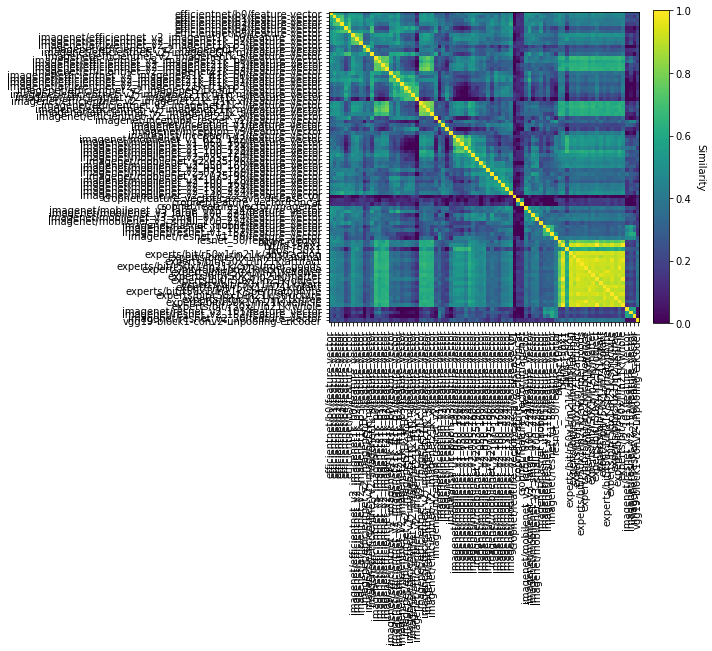

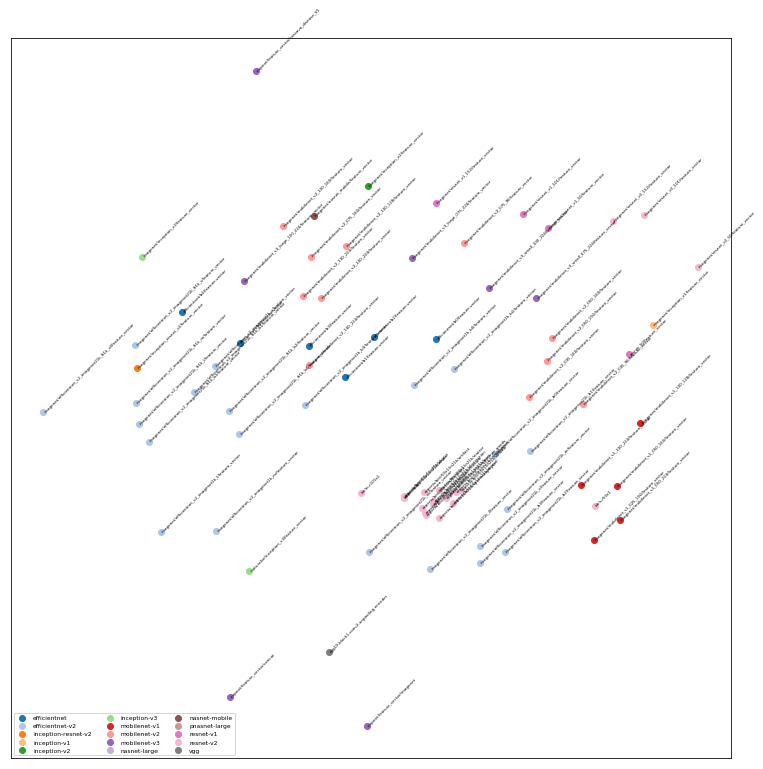

In [16]:
# Load hub similarity data
hubPath = "../outputs/masterOutput/hubSimsKriegset.csv"
df = pd.read_csv(hubPath, index_col=0)

# Remove repeat models
repeatModels = ['tf2-preview/inception_v3/feature_vector', 'tf2-preview/mobilenet_v2/feature_vector', 'experts/bit/r50x1/in21k/food', 'experts/bit/r50x1/in21k/arthropod', 'experts/bit/r50x1/in21k/instrument']
# Remove any row with a repeat model
df = df[~df.model1.isin(repeatModels)]
df = df[~df.model2.isin(repeatModels)]
df.head()

# Load hud mobel info
with open("../python_scripts/hubModels.json") as f:
    hubInfo = json.load(f)

# Get each type of model
modelTypes = np.sort(np.unique([hubInfo[key]['type'] for key in hubInfo.keys()]))
modelTypes

# Reorder models by type
models = []
for modelType in modelTypes:
    # Get models that are of this type
    tmp = [key for key in hubInfo.keys() if hubInfo[key]['type'] == modelType]

    # Filter to only models with hub sims
    tmp = [key for key in tmp if key in df.model1.unique() or key in df.model2.unique()]

    # Sort by name then add to list
    models += np.sort(tmp).tolist()

modelTypeColors = plt.cm.tab20(range(len(modelTypes)))

# Loop through all models and get their color
modelColors = []
modelGrouping = []
for model in models:
    # Get index of modeltype in modelTypes
    idx = np.where(modelTypes == hubInfo[model]['type'])[0][0]
    modelColors.append(modelTypeColors[idx])

    # Add model type to groupings
    modelGrouping.append(hubInfo[model]['type'])
# Create a heatmap for rsa by looping through rows similarity df
rsaHeatmap = np.zeros((len(models), len(models)))
for idx, row in df.iterrows():
    # Find the index of the models
    i = np.where(models == np.array(row.model1))[0][0]
    j = np.where(models == np.array(row.model2))[0][0]
    rsaHeatmap[i, j] = row.eucRsa
    rsaHeatmap[j, i] = row.eucRsa

rsaHeatmap[rsaHeatmap == 0] = 1

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(rsaHeatmap, vmin=0, vmax=1)

# Add scale
ax.set_xticks(np.arange(len(models)))
ax.set_yticks(np.arange(len(models)))
ax.set_xticklabels(models, rotation=90)
ax.set_yticklabels(models)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Similarity", rotation=-90, va="bottom")

# Save figure
plt.tight_layout()
plt.savefig("../visualization/maxVarSimMatRSA.svg", dpi=300)
rsaMDS = MDS(n_components=2, metric=True, dissimilarity="precomputed")
rsaMDS = rsaMDS.fit_transform(np.abs(1-rsaHeatmap))

# Plot MDS
fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes([0, 0, 1, 1])
for (modelType, color) in zip(modelTypes, modelTypeColors):
    ax.scatter(rsaMDS[:, 0][modelGrouping == np.array(modelType)], rsaMDS[:, 1][modelGrouping == np.array(modelType)], color=color, label=modelType)
    
# Remove axis ticks/labels
ax.set_xticks([])
ax.set_yticks([])

# Add legend outside
fig.legend(loc='lower left', bbox_to_anchor=(0, 0), ncol=3, fancybox=True, shadow=False, prop={'size': 6})

# Add text
for i, txt in enumerate(models):
    # Add rotation
    ax.annotate(txt, (rsaMDS[:, 0][i], rsaMDS[:, 1][i]), rotation=45, size=4)